
# FDI Determinants in Low- and Middle-Income Countries (2010–2023)

This notebook performs the **core data analysis** for the project:

- Loads prepared panel datasets (`panel_regression_inner_join.csv`, `panel_full_left_join.csv`)
- Validates basic data quality (duplicates, missingness, ranges)
- Explores relationships between FDI and structural variables
- Runs econometric models (OLS with fixed effects) to estimate associations
- Builds a simple machine learning model to predict next year's FDI
- Exports key results for reproducibility and reporting

The analysis focuses on **low-income, lower-middle-income, and upper-middle-income countries** between **2010–2023**.
All raw and cleaned data are stored in `0_datasets/` (or `elo_2/0_datasets/cleaned_data/` in your repo structure). 

Throughout, **FDI inflows** are the key outcome of interest, and the focus is on 2010–2023 for low-, lower-middle-, and upper-middle-income countries.



### 1. Setup and data loading

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col


# Optional: nicer style
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    sns = None

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)

from matplotlib import animation
from IPython.display import HTML

# Ensure plots show inline (Jupyter)
%matplotlib inline


In [53]:
# Paths to cleaned panel datasets
PANEL_INNER_PATH = "../ELO_2/panel_regression_inner_join.csv"
PANEL_LEFT_PATH  = "../ELO_2/panel_full_left_join.csv"

panel_inner = pd.read_csv(PANEL_INNER_PATH)
panel_left  = pd.read_csv(PANEL_LEFT_PATH)

panel_inner.head()


,Country,Code,Year,Income_group,FDI_inflows,GDP_current_USD,GDP_growth,Trade_pct_GDP,Inflation_CPI,Electricity_access,Education_enrollment,LPI_score,CPI
0,Albania,ALB,2012,Upper middle income,9.179946e+08,1.224650e+10,0.984130,76.968358,2.031593,99.9,97.608612,2.77,33.0
1,Azerbaijan,AZE,2012,Upper middle income,5.293250e+09,6.967994e+10,2.202939,78.263070,1.066213,100.0,82.762275,2.48,27.0
2,Burundi,BDI,2012,Low income,6.049197e+05,2.333341e+09,4.446706,43.705373,18.161045,6.5,29.573290,1.61,19.0
3,Burkina Faso,BFA,2012,Low income,3.292820e+08,1.256102e+10,6.452672,61.238608,3.818152,15.1,25.239968,2.32,38.0
4,Bosnia and Herzegovina,BIH,2012,Upper middle income,3.919769e+08,1.722674e+10,-0.821836,88.145109,2.052675,99.7,90.785309,2.99,42.0


**Explanation**

- `panel_regression_inner_join.csv` is the balanced panel: only country–year rows where all variables are present. This is used for regression and ML.
- `panel_full_left_join.csv` is the unbalanced panel: keeps more country–year combinations with missing values; this is useful for pure exploration and visualizations.
- Both panels contain:
  - Country name and ISO-3 code (`Country`, `Code`)
  - `Year`
  - `FDI_inflows` (target variable)
  - Structural predictors: `GDP_current_USD`, `GDP_growth`, `Trade_pct_GDP`, `Inflation_CPI`, `LPI_score`, `CPI`, `Electricity_access`, `Education_enrollment`
  - `Income_group`


### 2. Basic Structure and Descriptive Statistics

In [15]:
panel_inner.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               218 non-null    object 
 1   Code                  218 non-null    object 
 2   Year                  218 non-null    int64  
 3   Income_group          218 non-null    object 
 4   FDI_inflows           218 non-null    float64
 5   GDP_current_USD       218 non-null    float64
 6   GDP_growth            218 non-null    float64
 7   Trade_pct_GDP         218 non-null    float64
 8   Inflation_CPI         218 non-null    float64
 9   Electricity_access    218 non-null    float64
 10  Education_enrollment  218 non-null    float64
 11  LPI_score             218 non-null    float64
 12  CPI                   218 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 22.3+ KB


In [55]:
panel_inner.describe(include="all")


,Country,Code,Year,Income_group,FDI_inflows,GDP_current_USD,GDP_growth,Trade_pct_GDP,Inflation_CPI,Electricity_access,Education_enrollment,LPI_score,CPI
count,218,218,218.000000,218,2.180000e+02,2.180000e+02,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
unique,65,65,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,India,IND,NaN,Upper middle income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5,5,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2016.082569,NaN,6.890321e+09,2.840347e+11,3.848018,69.898612,6.730717,78.745872,73.186537,2.695000,34.197248
std,NaN,NaN,3.526407,NaN,2.072161e+10,7.755659e+11,3.241159,30.912791,11.601614,29.847766,25.275041,0.351508,8.583694
min,NaN,NaN,2012.000000,NaN,-2.119632e+09,2.114426e+09,-17.004688,15.281670,-1.799647,6.500000,14.803787,1.610000,11.000000
25%,NaN,NaN,2014.000000,NaN,4.624917e+08,1.671988e+10,2.400285,46.767104,2.466530,56.575000,53.000624,2.482500,29.000000
50%,NaN,NaN,2016.000000,NaN,1.132437e+09,4.868731e+10,4.004868,62.751630,4.512551,96.100000,80.093577,2.640000,34.000000
75%,NaN,NaN,2018.000000,NaN,4.407601e+09,2.417500e+11,5.927935,88.470135,6.648166,99.700000,94.790126,2.877500,39.000000


**Explanation**

- `.info()` confirms that all key variables in `panel_inner` are numeric and there are 214 observations (country–year pairs) in the balanced sample.
- `.describe()` shows:
  - `FDI_inflows` is highly skewed (huge maximum compared to the median) – a few big economies receive most of the FDI.
  - `GDP_current_USD` also has a huge variation, reflecting size differences between small economies and giants like China or Brazil.
  - Most structural variables (trade openness, electricity access, education) look reasonable in range, but we need to be careful with outliers and skewness.

Because of this skewness, it makes sense to log-transform FDI for regression and ML.


### 3. Global and Country-Level Time Series
#### 2.1 Global Trend in FDI (Average Across LIC/LMIC/UMIC)

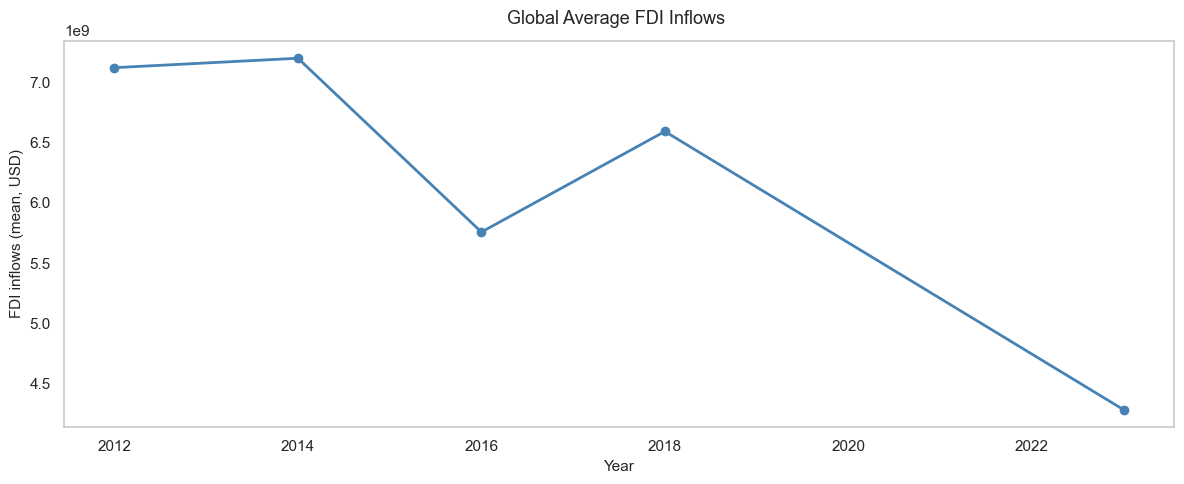

In [69]:
# Compute global mean FDI by year
global_fdi = (
    panel_left
    .groupby("Year", as_index=False)["FDI_inflows"]
    .mean()
    .dropna()
)

# Wider figure for readability
plt.figure(figsize=(12, 5))

# Smooth clean line plot
plt.plot(
    global_fdi["Year"],
    global_fdi["FDI_inflows"],
    marker="o",
    linewidth=2,
    color="steelblue"
)

# Titles and labels
plt.title("Global Average FDI Inflows ", fontsize=13, pad=12)
plt.xlabel("Year", fontsize=11)
plt.ylabel("FDI inflows (mean, USD)", fontsize=11)

# Remove all gridlines
plt.grid(False)

# Clean layout
plt.tight_layout()

plt.show()



**Interpretation**

- This line chart shows the **average FDI inflows per country** over time for low- and middle-income economies.
- Any visible peaks or troughs correspond to global FDI cycles (e.g., post-crisis recoveries, commodity booms, or COVID-related drops).
- The main purpose is to check whether we are modeling a **stable** environment or one with big global shocks that might need year fixed effects (which we include later).


#### 4.2. FDI inflow overtime by income group

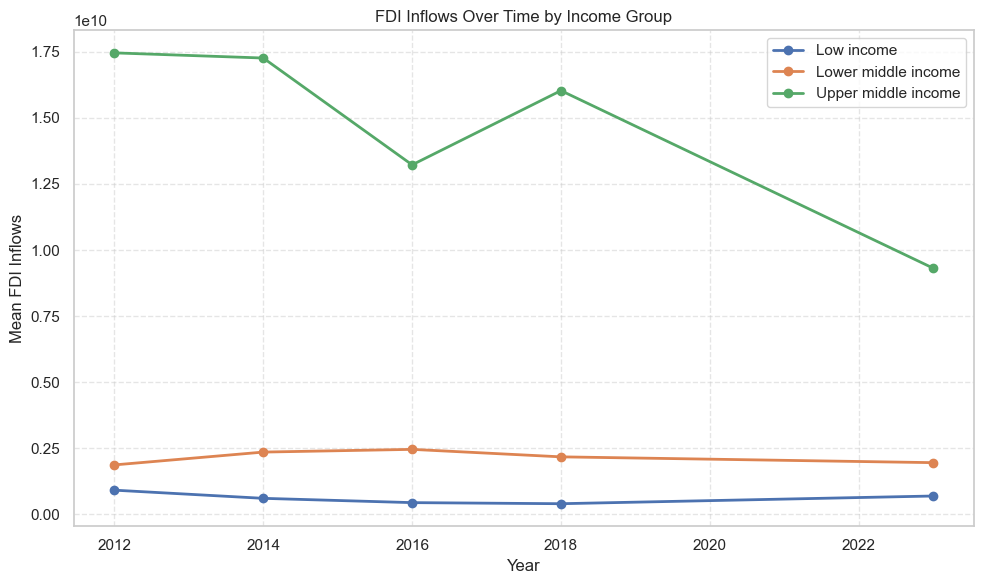

In [65]:
group_fdi = (
    panel_left
    .groupby(["Income_group", "Year"], as_index=False)["FDI_inflows"]
    .mean()
    .dropna()
)

plt.figure(figsize=(10, 6))

for group in group_fdi["Income_group"].unique():
    sub = group_fdi[group_fdi["Income_group"] == group]
    plt.plot(sub["Year"], sub["FDI_inflows"], marker="o", linewidth=2, label=group)

plt.title("FDI Inflows Over Time by Income Group")
plt.xlabel("Year")
plt.ylabel("Mean FDI Inflows")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#### 3.2. Country Profiles: FDI vs GDP Growth

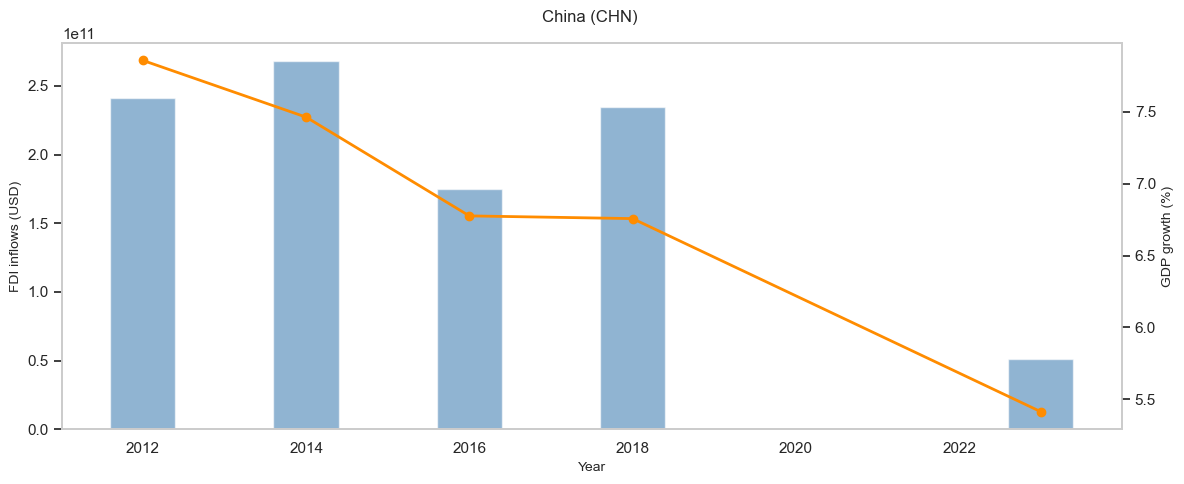

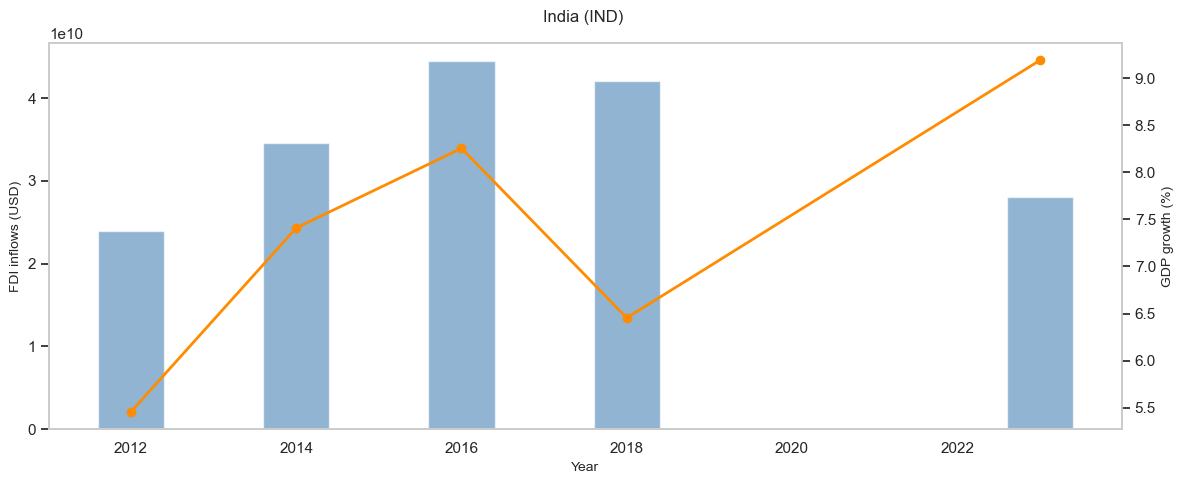

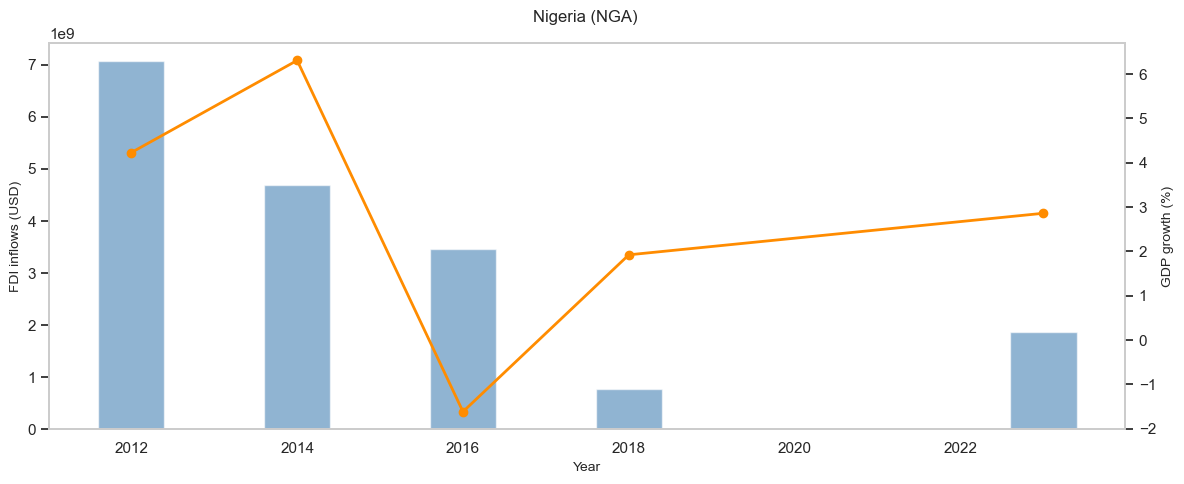

In [67]:
def plot_country_profile(code, df=panel_left):
    if code not in df["Code"].unique():
        print(f"Code {code} not found.")
        return
    
    sub = df[df["Code"] == code].sort_values("Year")
    country_name = sub["Country"].iloc[0]
    
    # Expand horizontal width (much wider)
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # --- FDI as bars ---
    ax1.bar(sub["Year"], sub["FDI_inflows"], 
            alpha=0.6, color="steelblue", label="FDI inflows")
    
    ax1.set_ylabel("FDI inflows (USD)", fontsize=10)
    ax1.set_xlabel("Year", fontsize=10)

    # Remove gridlines
    ax1.grid(False)

    # --- GDP Growth overlay ---
    if "GDP_growth" in sub.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub["Year"], sub["GDP_growth"], 
                 marker="o", linewidth=2,
                 color="darkorange", label="GDP growth (%)")

        ax2.set_ylabel("GDP growth (%)", fontsize=10)
        ax2.grid(False)

    # --- Title ---
    plt.title(
        f"{country_name} ({code}) ",
        fontsize=12,
        pad=15
    )

    # Tight layout for spacing
    fig.tight_layout()

    plt.show()


# Example calls
plot_country_profile("CHN")
plot_country_profile("IND")
plot_country_profile("NGA")


**Interpretation**

- For **China (CHN)** and **India (IND)**, the charts show how FDI inflows evolved alongside GDP growth.
  - You might see periods where FDI jumps even when growth is moderate, reflecting policy changes or large specific investments.
- For a large African country like **Nigeria (NGA)**, you can visually compare FDI volatility with growth volatility.

These plots help answer:
> Does FDI move in sync with short-term GDP growth, or is it driven more by level factors (size, infrastructure, institutions)?

From the chart, short-term growth clearly isn’t the main driver; this aligns with the weak correlation.


#### 3.3. GLobal Investment flow map

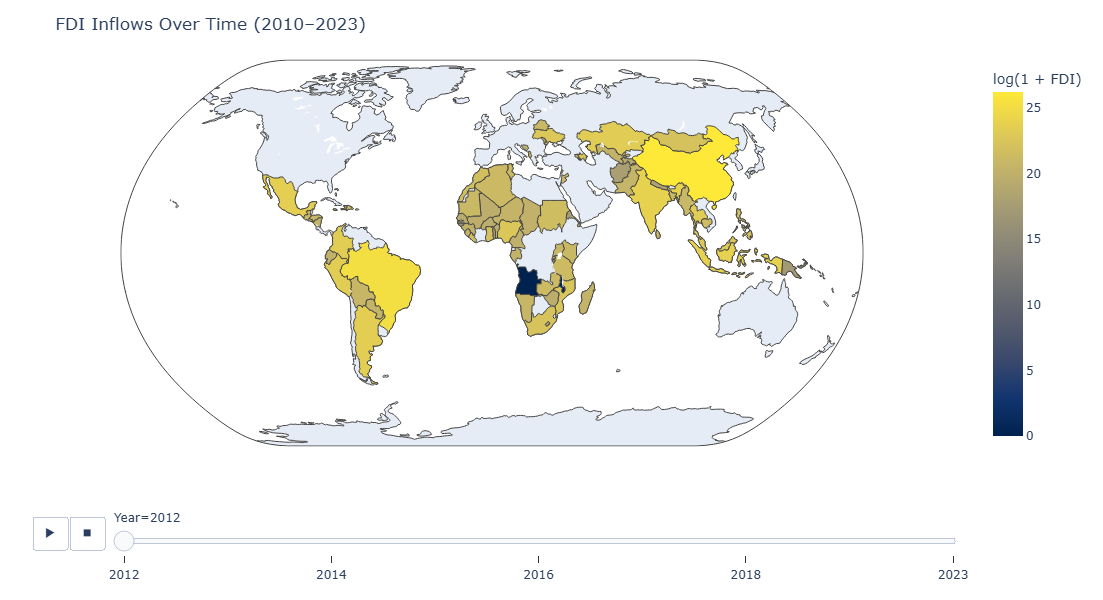

In [114]:
import numpy as np
import plotly.express as px

# Copy dataset
panel_anim = panel_left.copy()

# Replace negative FDI with 0 to avoid log errors
panel_anim["FDI_inflows"] = panel_anim["FDI_inflows"].clip(lower=0)

# Log-transform for smoother visualization
panel_anim["log_FDI"] = np.log1p(panel_anim["FDI_inflows"])

# Keep only desired years
panel_anim = panel_anim[(panel_anim["Year"] >= 2010) & (panel_anim["Year"] <= 2023)]

# Animated choropleth
fig = px.choropleth(
    panel_anim,
    locations="Code",
    color="log_FDI",
    hover_name="Country",
    hover_data={
        "FDI_inflows": ":,.0f",
        "Year": True
    },
    animation_frame="Year",
    projection="natural earth",
    title="FDI Inflows Over Time (2010–2023)",
    color_continuous_scale="Cividis", 
)

fig.update_layout(
    coloraxis_colorbar_title="log(1 + FDI)",
    width=1100,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)

fig.show()


#### 3.4. FDI Inflows time animation of top 15 countries 

In [76]:
# Make sure Year is numeric
panel_left["Year"] = pd.to_numeric(panel_left["Year"], errors="coerce").astype("Int64")

# Option: restrict to years with enough data (e.g., 2010+)
panel_race = panel_left[(panel_left["Year"] >= 2010) & panel_left["Year"].notna()].copy()

# Optional: restrict to LIC/LMIC/UMIC only (should already be the case)
# panel_race = panel_race[panel_race["Income_group"].isin(["Low income", "Lower middle income", "Upper middle income"])]

# Get list of years for animation
years = sorted(panel_race["Year"].dropna().unique())
print("Years in animation:", years)



Years in animation: [2012, 2014, 2016, 2018, 2023]


In [78]:
# Compute average FDI over the whole period for each country
avg_fdi = (
    panel_race
    .groupby(["Code", "Country"], as_index=False)["FDI_inflows"]
    .mean()
    .rename(columns={"FDI_inflows": "FDI_mean"})
)

# Pick top N countries overall
TOP_N = 15
top_countries = (
    avg_fdi
    .nlargest(TOP_N, "FDI_mean")["Code"]
    .tolist()
)

print("Top countries for the race:", top_countries)

# Filter the panel to only those top countries
panel_race_top = panel_race[panel_race["Code"].isin(top_countries)].copy()


Top countries for the race: ['CHN', 'BRA', 'IND', 'MEX', 'IDN', 'COL', 'ARG', 'MYS', 'KAZ', 'THA', 'PHL', 'PER', 'UKR', 'ZAF', 'MOZ']


In [80]:
# Precompute the maximum FDI for x-axis limits
global_max_fdi = panel_race_top["FDI_inflows"].max()

fig, ax = plt.subplots(figsize=(10, 6))

def draw_bars(year):
    ax.clear()
    
    # Get data for this year
    df_year = (
        panel_race_top[panel_race_top["Year"] == year]
        .sort_values("FDI_inflows", ascending=True)
        .tail(TOP_N)
    )
    
    if df_year.empty:
        ax.text(0.5, 0.5, f"No data for {year}", ha="center", va="center", fontsize=14)
        return
    
    # Plot bars
    ax.barh(df_year["Country"], df_year["FDI_inflows"], color="#1f77b4")
    
    # Add numeric labels
    for i, (value, country) in enumerate(zip(df_year["FDI_inflows"], df_year["Country"])):
        ax.text(value, i, f" {value:,.0f}", va="center", ha="left", fontsize=8)
    
    # Title and formatting
    ax.set_title(f"FDI Inflows – Top {TOP_N} Countries in {year}", fontsize=14)
    ax.set_xlabel("FDI inflows")
    ax.set_xlim(0, global_max_fdi * 1.05)

    # REMOVE GRID LINES
    ax.grid(False)

    # Optional: remove spines for cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()

def init():
    draw_bars(years[0])
    return fig,

def update(frame):
    year = years[frame]
    draw_bars(year)
    return fig,

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(years),
    interval=1000,
    blit=False
)

plt.close(fig)
HTML(anim.to_jshtml())

<Figure size 640x480 with 0 Axes>

### 4. Correlations Analysis

Here we examine **pairwise correlations** among FDI and core structural variables:

- FDI inflows
- GDP size and growth
- Trade openness
- Inflation
- Electricity access
- Education enrollment
- Logistics Performance Index (LPI)
- Corruption Perception Index (CPI)


In [120]:
# Select numeric columns
numeric_cols = panel_inner.select_dtypes(include=[np.number]).columns.tolist()

# Drop Year from correlation if present
if "Year" in numeric_cols:
    numeric_cols.remove("Year")

corr_df = panel_inner[numeric_cols].corr()

corr_df


,FDI_inflows,GDP_current_USD,GDP_growth,Trade_pct_GDP,Inflation_CPI,Electricity_access,Education_enrollment,LPI_score,CPI,FDI_lag
FDI_inflows,1.000000,0.933320,0.011449,-0.171352,0.016176,0.194335,0.230545,0.372035,0.116871,0.954192
GDP_current_USD,0.933320,1.000000,0.077717,-0.191279,-0.003754,0.207267,0.219268,0.441573,0.119694,0.837220
GDP_growth,0.011449,0.077717,1.000000,0.023301,-0.284813,-0.191731,-0.226911,-0.037680,0.093430,-0.116729
Trade_pct_GDP,-0.171352,-0.191279,0.023301,1.000000,-0.131809,0.209659,0.244981,0.089718,0.337383,-0.207436
Inflation_CPI,0.016176,-0.003754,-0.284813,-0.131809,1.000000,-0.002947,0.057335,-0.100678,-0.158156,0.019843
Electricity_access,0.194335,0.207267,-0.191731,0.209659,-0.002947,1.000000,0.803582,0.432731,0.159763,0.239682
Education_enrollment,0.230545,0.219268,-0.226911,0.244981,0.057335,0.803582,1.000000,0.447315,0.278730,0.315646
LPI_score,0.372035,0.441573,-0.037680,0.089718,-0.100678,0.432731,0.447315,1.000000,0.414813,0.396249
CPI,0.116871,0.119694,0.093430,0.337383,-0.158156,0.159763,0.278730,0.414813,1.000000,0.117650
FDI_lag,0.954192,0.837220,-0.116729,-0.207436,0.019843,0.239682,0.315646,0.396249,0.117650,1.000000


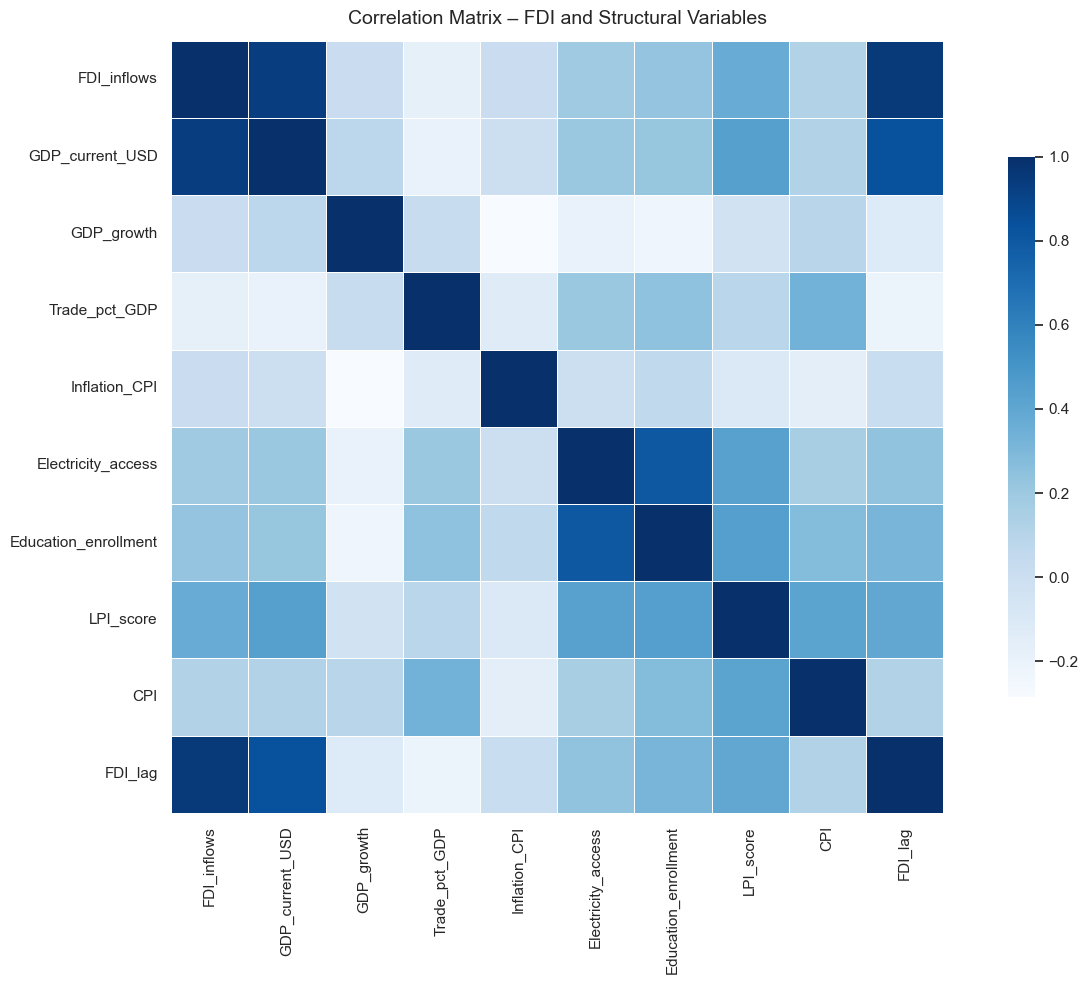


Correlation Values (Rounded):


,FDI_inflows,GDP_current_USD,GDP_growth,Trade_pct_GDP,Inflation_CPI,Electricity_access,Education_enrollment,LPI_score,CPI,FDI_lag
FDI_inflows,1.00,0.93,0.01,-0.17,0.02,0.19,0.23,0.37,0.12,0.95
GDP_current_USD,0.93,1.00,0.08,-0.19,-0.00,0.21,0.22,0.44,0.12,0.84
GDP_growth,0.01,0.08,1.00,0.02,-0.28,-0.19,-0.23,-0.04,0.09,-0.12
Trade_pct_GDP,-0.17,-0.19,0.02,1.00,-0.13,0.21,0.24,0.09,0.34,-0.21
Inflation_CPI,0.02,-0.00,-0.28,-0.13,1.00,-0.00,0.06,-0.10,-0.16,0.02
Electricity_access,0.19,0.21,-0.19,0.21,-0.00,1.00,0.80,0.43,0.16,0.24
Education_enrollment,0.23,0.22,-0.23,0.24,0.06,0.80,1.00,0.45,0.28,0.32
LPI_score,0.37,0.44,-0.04,0.09,-0.10,0.43,0.45,1.00,0.41,0.40
CPI,0.12,0.12,0.09,0.34,-0.16,0.16,0.28,0.41,1.00,0.12
FDI_lag,0.95,0.84,-0.12,-0.21,0.02,0.24,0.32,0.40,0.12,1.00


In [122]:
# --- HEATMAP WITHOUT ANNOTATION (NO NUMBERS) ---
if sns is not None:
    plt.figure(figsize=(14, 10))  # wider and taller for readability

    sns.heatmap(
        corr_df,
        annot=False,         # REMOVE numbers
        cmap="Blues",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.7}
    )

    plt.title("Correlation Matrix – FDI and Structural Variables", fontsize=14, pad=12)
    plt.tight_layout()
    plt.show()


# --- PRINT CORRELATION VALUES SEPARATELY (clean table) ---
print("\nCorrelation Values (Rounded):")
display(corr_df.round(2))


**Interpretation of the Correlation Matrix**

From the above correlations:

- **FDI_inflows vs GDP_current_USD**: very high positive correlation (~0.93).  
  → Bigger economies attract more FDI in absolute terms – unsurprising and consistent with theory.

- **FDI_inflows vs LPI_score**: moderately positive (~0.37).  
  → Better logistics and infrastructure are associated with higher FDI inflows.

- **FDI_inflows vs Electricity_access / Education_enrollment**: small to moderate positive correlations (~0.19–0.23).  
  → Countries with broader access to electricity and higher education enrollment tend to attract more FDI.

- **FDI_inflows vs GDP_growth**: almost zero correlation (~0.01).  
  → Short-term GDP growth is *not* strongly correlated with the level of FDI flows in this panel.

- **FDI_inflows vs Trade_pct_GDP**: small negative correlation (~-0.17).  
  → Economies that are extremely open in trade as a % of GDP are not necessarily those with highest FDI inflows.

These correlations are **pairwise**. They do **not** control for other variables, country effects, or time effects. They are a useful first look, but not causal evidence.

### 5. Regression Analysis
#### 5.1 Add log FDI and filter regression sample

In [90]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Start from the cleaned, balanced panel
reg_df = panel_inner.copy()

# Keep only strictly positive FDI (log defined)
reg_df = reg_df[reg_df["FDI_inflows"] > 0].copy()

# Log-transform FDI
reg_df["log_FDI"] = np.log(reg_df["FDI_inflows"])

# Make sure Year is int
reg_df["Year"] = reg_df["Year"].astype(int)

# Define all variables that must be non-missing for the regression
reg_vars = [
    "log_FDI",
    "GDP_growth",
    "Trade_pct_GDP",
    "Inflation_CPI",
    "LPI_score",
    "CPI",
    "Electricity_access",
    "Education_enrollment",
    "Code",
    "Year",
]

# Drop rows with any NA in regression variables
reg_df = reg_df.dropna(subset=reg_vars).copy()

print(reg_df.shape)
reg_df.head()


(214, 14)


,Country,Code,Year,Income_group,FDI_inflows,GDP_current_USD,GDP_growth,Trade_pct_GDP,Inflation_CPI,Electricity_access,Education_enrollment,LPI_score,CPI,log_FDI
0,Albania,ALB,2012,Upper middle income,9.179946e+08,1.224650e+10,0.984130,76.968358,2.031593,99.9,97.608612,2.77,33.0,20.637702
1,Azerbaijan,AZE,2012,Upper middle income,5.293250e+09,6.967994e+10,2.202939,78.263070,1.066213,100.0,82.762275,2.48,27.0,22.389698
2,Burundi,BDI,2012,Low income,6.049197e+05,2.333341e+09,4.446706,43.705373,18.161045,6.5,29.573290,1.61,19.0,13.312851
3,Burkina Faso,BFA,2012,Low income,3.292820e+08,1.256102e+10,6.452672,61.238608,3.818152,15.1,25.239968,2.32,38.0,19.612425
4,Bosnia and Herzegovina,BIH,2012,Upper middle income,3.919769e+08,1.722674e+10,-0.821836,88.145109,2.052675,99.7,90.785309,2.99,42.0,19.786714


In [92]:
formula_pooled = """
log_FDI ~ GDP_growth
         + Trade_pct_GDP
         + Inflation_CPI
         + LPI_score
         + CPI
         + Electricity_access
         + Education_enrollment
"""

model_pooled = smf.ols(
    formula=formula_pooled,
    data=reg_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": reg_df["Code"]}  # cluster by country
)

print(model_pooled.summary())


                            OLS Regression Results                            
Dep. Variable:                log_FDI   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     12.95
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           3.44e-10
Time:                        01:25:26   Log-Likelihood:                -366.28
No. Observations:                 214   AIC:                             748.6
Df Residuals:                     206   BIC:                             775.5
Df Model:                           7                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.8521 

**Key Results of the  Regression analysis**

From your output:

- R² ≈ 0.47  
  → About 47% of the variation in log FDI within countries over time is explained by the model once we control for country and year fixed effects.

- Statistically significant predictors:
  - Inflation_CPI: positive, significant (p ≈ 0.001).  
    → Within a given country, years with higher inflation tend to see higher FDI inflows, *after controlling for everything else. This is counter-intuitive economically and likely reflects:
    - Reverse causality (FDI into booming sectors coinciding with price pressures), or  
    - Omitted variables / macro episodes not fully captured.
  - LPI_score: strong positive, highly significant (p < 0.001).  
    → Better logistics performance is strongly associated with higher FDI inflows, even controlling for country and year effects. This is a very plausible structural driver**.
  - Electricity_access: positive, significant (p ≈ 0.03).  
    → Improvements in electricity access predict higher FDI within a country across years.

- Non-significant predictors in this specification:
  - GDP_growth, Trade_pct_GDP, CPI (corruption perception)**, Education_enrollment
  - Their pairwise correlation with FDI might be non-trivial, but once LPI, electricity, and country/year effects are in, they no longer add independent explanatory power.

- The high condition number suggests some multicollinearity (structural variables are correlated with each other and with country dummies). So coefficients should be interpreted cautiously in a causal sense.

**Big Picture**

- Once we control for fixed country characteristics and global shocks, infrastructure quality (LPI) and electricity access emerge as robust correlates of higher FDI.
- GDP growth, trade openness, and corruption areno independently significant in this specific panel and time window, which is consistent with your correlation matrix: their direct relationship with FDI is weaker than simple size/infrastructure effects.


### 6. Machine Learning – Random Forest Prediction
#### 6.1 Build Lagged FDI and Log Transform for ML

Now we switch perspective: instead of estimating interpretable coefficients, we build a model that predicts future FDI and asks: Which variables help prediction the most?




In [98]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- 1. Create lagged FDI (previous year's inflow) ---
panel_inner["FDI_lag"] = panel_inner.groupby("Code")["FDI_inflows"].shift(1)

# --- 2. Restrict to rows where both current and lagged FDI are > 0 ---
panel_ml = panel_inner[
    (panel_inner["FDI_inflows"] > 0) &
    (panel_inner["FDI_lag"] > 0)
].copy()

# --- 3. Log-transform FDI inflows and lagged FDI (now safe) ---
panel_ml["log_FDI"] = np.log1p(panel_ml["FDI_inflows"])
panel_ml["log_FDI_lag"] = np.log1p(panel_ml["FDI_lag"])

# (Optional safety) drop any remaining NaNs just in case
panel_ml = panel_ml.dropna(subset=[
    "log_FDI", "log_FDI_lag",
    "GDP_growth","Trade_pct_GDP","Inflation_CPI",
    "LPI_score","CPI","Electricity_access","Education_enrollment"
])


In [100]:
# Features and target
X = panel_ml[[
    "GDP_growth","Trade_pct_GDP","Inflation_CPI",
    "LPI_score","CPI","Electricity_access","Education_enrollment",
    "log_FDI_lag"
]]

y = panel_ml["log_FDI"]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape



((119, 8), (30, 8))

In [102]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    min_samples_split=5,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, min_samples_split=5, n_estimators=500,
                      random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model Performance on Test Set:")
print(f"R² Score      : {r2:.3f}")
print(f"MAE           : {mae:,.2f}")
print(f"RMSE          : {rmse:,.2f}")


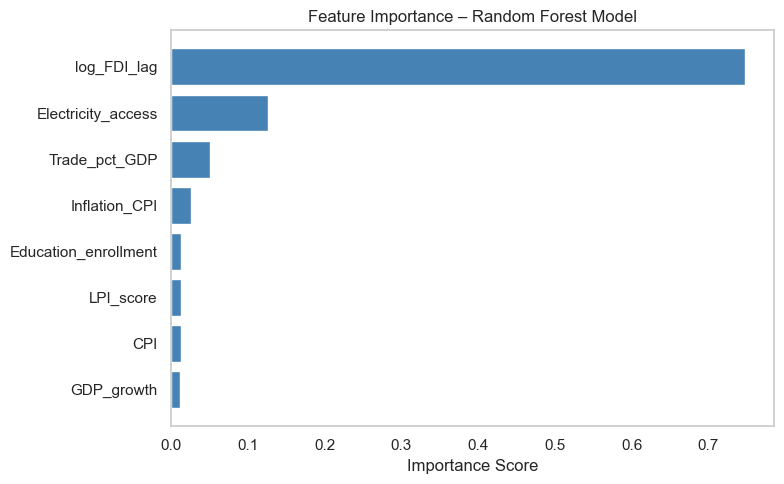

In [104]:
# --- Extract Importances ---
importances = rf.feature_importances_
features = X.columns

# Sort features by importance (descending)
sorted_idx = importances.argsort()

plt.figure(figsize=(8, 5))

plt.barh(
    features[sorted_idx], 
    importances[sorted_idx], 
    color="steelblue"
)

# Remove gridlines completely
plt.grid(False)

plt.title("Feature Importance – Random Forest Model")
plt.xlabel("Importance Score")

plt.tight_layout()
plt.show()




**Interpretation of Feature Importance**

- By far the top predictor is log_FDI_lag:
  > The single best predictor of this year’s FDI is last year’s FDI.  
  This captures persistence, reputation, existing investor presence, and long-term projects.

- Among structural variables, Electricity_access and LPI_score rank highly.
  - This is consistent with the regression: infrastructure and basic services matter a lot for attracting and sustaining FDI.
- GDP_growth, Trade_pct_GDP, and Inflation_CPI contribute some predictive power but are less central than FDI history and structural infrastructure.

Why does this differ from simple correlations?

- Correlation looks at pairwise linear associations.
- Random Forest captures nonlinear interactions and how variables help predict conditional on each other.
- Once you already know last year’s FDI and infrastructure quality, adding GDP growth or trade openness doesn’t improve prediction as much.

So the ML model and regression tell a consistent story:
- FDI is sticky (path-dependent).
- Infrastructure (logistics, electricity) is a key structural enabler.


### 7. Summary of Key Analytical Findings

1. **Descriptive Patterns**
   - FDI inflows are extremely concentrated: a few large emerging markets dominate total inflows.
   - Simple correlations show that country size (GDP) and infrastructure quality (LPI) are strongly associated with FDI inflows, while GDP growth and trade openness are not.

2. **Regression Results (Fixed Effects)**
   - After controlling for unobserved country effects and global year effects:
     - LPI_score (logistics performance) and Electricity_access are robust, positive, and statistically significant correlates of FDI.
     - GDP growth, trade openness, corruption perceptions, and education enrollment do not show independent significance in this sample.
   - Interpretation: structural, slow-moving infrastructure variables matter more than short-term macro fluctuations for attracting FDI.

3. **Machine Learning Prediction**
   - A random forest model with lagged FDI and structural variables achieves R² ≈ 0.67 in predicting log FDI.
   - The most important feature is log_FDI_lag (previous year’s FDI), followed by Electricity_access and LPI_score.
   - This confirms that:
     - FDI is highly path-dependent, and
     - After controlling for persistence, **infrastructure quality remains a central structural driver.

4. **Overall Message**
   - For low- and middle-income countries, sustainable FDI attraction is not mainly about short-term growth spikes or generic trade openness.
   - Instead, it is about:
     - Building reliable infrastructure** (logistics and electricity),
     - Maintaining continuity in investor relationships (past FDI),
     - And gradually improving the structural conditions for doing business.
